In [129]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as la


In [130]:
#Practical
def tridiag(lower, diag, upper, size):
    A=np.diag(lower, -1) + np.diag(diag) + np.diag(upper, 1)
    return A

In [131]:
#I.C, this defines f in the functions below
def european_put(x, strike_K, strike_H, R, M):
    europe=np.array(strike_K-x)
    europe[int((strike_K*M)/R):]=0
    return europe

def butterfly(x, strike_K, strike_H, R, M):
    term1=np.array(x-strike_K)
    term1[:int((strike_K*M)/R)]=0
    
    term2=2*np.array(x-(strike_K+strike_H))
    term2[:int(((strike_K+strike_H)*M)/R)]=0
    
    term3=np.array(x-(strike_K+2*strike_H))
    term3[:int(((strike_K+2*strike_H)*M)/R)]=0
    
    butterfly=term1-term2+term3
    
    return butterfly

def binary(x, strike_K, strike_H, R, M):
    arr=np.ones(len(x))
    indices=np.where(x-strike_K<0)
    np.put(arr, indices, 0)
    return arr

def boundary_0(t, strike_K, c):                  #How to choose this c value?
    return strike_K*np.exp(-c*t)

def boundary_R_european(R, K, H, t=None):
    return max((K-R), 0)

def boundary_R_butterfly(R, K, H, t=None):
    butterfly=max(R-K, 0) - 2*max((R-(K+H)), 0) + max((R-(K+2*H)), 0)
    return butterfly

def boundary_R_binary(R, K, H, t=None):
    if (R-K)<0:
        return 0
    else:
        return 1

In [169]:
#Solvers in time and a plot function:

import time


def forward_euler(R, M, T, N, sigma, r, c, IC, strike_K, strike_H, BC0, BCR):
    
    h=R/M
    k=T/N
    
    U=np.zeros((M+1, N+1))        #How to choose M?   MxN matrix still, easier plots
    x=np.linspace(0, R, (M+1))    #Remember to add stability condition with positive coefficient in tridiag
    t=np.linspace(0, T, N+1)      #Probably necessary to have many more timesteps and spacesteps for conv
    
    U[:, 0]=IC(x, strike_K, strike_H, R, M)
    U[0, :]=BC0(t, U[0, 0], c)
    
    U[-1,:]=BCR(R, strike_K, strike_H, t=t)
    
    
    A=tridiag(((k*sigma**2*x[2:-1]**2)/(2*h**2) - (k*r*x[2:-1])/(2*h)),
              (1-(k*sigma**2*x[1:-1]**2)/(h**2) - k*c),
              ((k*sigma**2*x[1:-2]**2)/(2*h**2) + (k*r*x[1:-2])/(2*h)), 
              M-1)
              
    CFL=np.diag(A)
    
    for n in range(N):
        U[1:-1, n+1]=A.dot(U[1:-1, n]) 
        
    
    return x, t, U, CFL




def backward_euler(R, M, T, N, sigma, r, c, IC, strike_K, strike_H, BC0, BCR):
    h=R/M
    k=T/N
    
    U=np.zeros((M+1,N+1))
    x=np.linspace(0, R, M+1)         #How to choose M?
    t=np.linspace(0, T, N+1)
    
    
    A=tridiag(((-k*sigma**2*x[2:-1]**2)/(2*h**2) + (k*r*x[2:-1])/(2*h)),
             (1+(k*sigma**2*x[1:-1]**2/(h**2)) + k*c), 
             ((-k*sigma**2*x[1:-2]**2/(2*h**2)) - (k*r*x[1:-2])/(2*h)), 
             M-1)
    
    U[:, 0]=IC(x, strike_K, strike_H, R, M)
    #U[0, :]=BC0(t, U[0, 0], c)
    #U[-1,:]=BCR(R, strike_K, strike_H)
    
    U[0, :]=BC0(t, U[0, 0], c)
    U[-1, :]=BCR(R, strike_K, strike_H)
    
    q=np.zeros(M-1)
    
    for n in range(N):
        q[0]=BC0(t[n+1], U[0, 0], c)*((-k*sigma**2*x[1]**2)/(2*h**2) + (k*r*x[1])/(2*h))
        q[-1]=BCR(R, strike_K, c)*((-k*sigma**2*x[M-1]**2)/(2*h**2) - (k*r*x[M-1])/(2*h))
        U_n=U[1:-1, n]
        U[1:-1, n+1]=la.solve(A, (U_n+q))
        
      
    return x, t, U



def crank_nicholson(R, M, T, N, sigma, r, c, IC, strike_K, strike_H, BC0, BCR):
    h=R/M
    k=T/N
    
    U=np.zeros((M+1,N+1))
    x=np.linspace(0, R, M+1)         #How to choose M?
    t=np.linspace(0, T, N+1)
    
    
    A=np.identity(M-1) - (1/2)*tridiag(((k*sigma**2*x[2:-1]**2)/(2*h**2) - (k*r*x[2:-1])/(2*h)), 
                    ((-k*sigma**2*x[1:-1]**2)/(h**2) - k*c),
                    ((k*sigma**2*x[1:-2]**2)/(2*h**2) + (k*r*x[1:-2])/(2*h)),
                    M-1)                                                                        #Invert this
    
    B=np.identity(M-1) + (1/2)*tridiag(((k*sigma**2*x[2:-1]**2/(2*h**2)) - (k*r*x[2:-1])/(2*h)), 
                    ((-k*sigma**2*x[1:-1]**2)/(h**2) - k*c),
                    ((k*sigma**2*x[1:-2]**2)/(2*h**2) + (k*r*x[1:-2])/(2*h)),
                    M-1)                                                                        #Update this
    
    U[:, 0]=IC(x, strike_K, strike_H, R, M)
    U[0, :]=BC0(t, U[0,0], c)
    U[-1,:]=BCR(R, strike_K, strike_H)
    
    q=np.zeros(M-1)
    explicit=B.dot(U[1:-1, 0])
    for n in range(N):
        q[0]=(1/2)*((BC0(t[n], U[0, 0], c)*((-k*sigma**2*x[1]**2)/(2*h**2) + (k*r*x[1])/(2*h))) + (BC0(t[n+1], U[0, 0], c)*((-k*sigma**2*x[1]**2)/(2*h**2) + (k*r*x[1])/(2*h))))
        q[-1]=BCR(R, strike_K, c)*((-k*sigma**2*x[M-1]**2)/(2*h**2) - (k*r*x[M-1])/(2*h))
        
        U_n=explicit+q
        
        U[1:-1, n+1]=la.solve(A, U_n)
        
        explicit=B.dot(U[1:-1, n+1])
    
    return x, t, U



def plot_solution(x1, t1, U1, x2, t2, U2, x3, t3, U3, method):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d"})
    T1, X1 = np.meshgrid(t1, x1)
    T2, X2 = np.meshgrid(t2, x2)
    T3, X3 = np.meshgrid(t3, x3)
    ax[0].plot_surface(T1, X1, U1, cmap=cm.coolwarm)
    ax[1].plot_surface(T2, X2, U2, cmap=cm.coolwarm)
    ax[2].plot_surface(T3, X3, U2, cmap=cm.coolwarm)
    ax[0].view_init(azim=50)              # Rotate the figure
    ax[1].view_init(azim=50)
    ax[2].view_init(azim=50)
    ax[0].set_title('European put')
    ax[1].set_title('Butterfly')
    ax[2].set_title('Binary')
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')
    ax[0].set_zlabel('u')
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('x')
    ax[1].set_zlabel('u')
    ax[2].set_xlabel('t')
    ax[2].set_ylabel('x')
    ax[2].set_zlabel('u')
    #fig.tight_layout()
    if method==0:
        fig.suptitle("Euler", fontsize=14)
    if method==1:
        fig.suptitle("Backward Euler", fontsize=14)
    if method==2:
        fig.suptitle("Crank Nicholson", fontsize=14)
    fig.tight_layout();
'''

def plot_solution(x1, t1, U1, method, title):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 7), subplot_kw={"projection": "3d"})
    T1, X1 = np.meshgrid(t1, x1)
    ax.plot_surface(T1, X1, U1, cmap=cm.coolwarm)
    ax.view_init(azim=50)              # Rotate the figure
    ax.set_title(title)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    
    fig.tight_layout()
    if method==0:
        fig.suptitle("Euler", fontsize=14)
    if method==1:
        fig.suptitle("Backward Euler", fontsize=14)
    if method==2:
        fig.suptitle("Crank Nicholson", fontsize=14);
'''
          

def u_exact(R, M, T, N):
    x=np.linspace(0, R, (M+1))    
    t=np.linspace(0, T, N+1)
    
    tt, xx=np.meshgrid(t, x)
    
    u=tt+xx**2
    return x, t, u

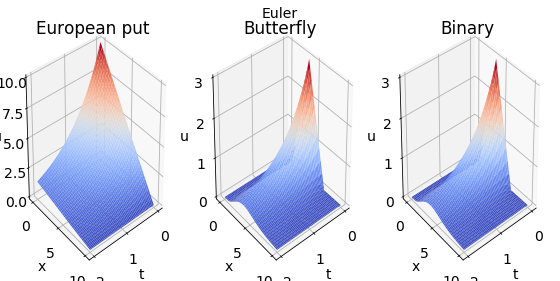

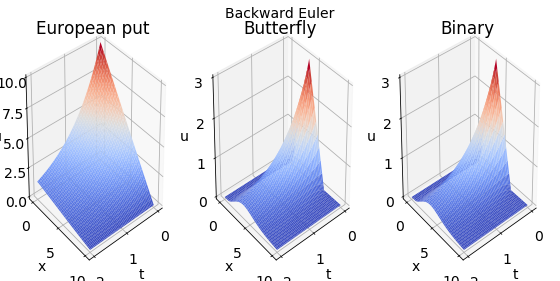

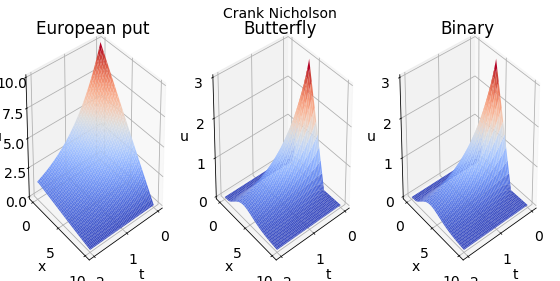

In [168]:
#Plots

R=10
M=100
T=2
N=1000
sigma=1/5
r=0.02
c=1


#With N=100 we get instability in FE
x_europe, t_europe, U_europe, CFL = forward_euler(R, M, T, N, sigma, r, c, european_put, 10, 0, boundary_0, boundary_R_european)
x_butterfly, t_butterfly, U_butterfly, CFL = forward_euler(R, M, T, N, sigma, r, c, butterfly, 1, 3, boundary_0, boundary_R_butterfly)
x_binary, t_binary, U_binary, CFL = forward_euler(R, M, T, N, sigma, r, c, binary, 1, 3, boundary_0, boundary_R_binary)

xB_europe, tB_europe, UB_europe = backward_euler(R, M, T, N, sigma, r, c, european_put, 10, 0, boundary_0, boundary_R_european)
xB_butterfly, tB_butterfly, UB_butterfly = backward_euler(R, M, T, N, sigma, r, c, butterfly, 1, 3, boundary_0, boundary_R_butterfly)    
xB_binary, tB_binary, UB_binary = backward_euler(R, M, T, N, sigma, r, c, binary, 1, 3, boundary_0, boundary_R_binary)    

xCN_europe, tCN_europe, UCN_europe = crank_nicholson(R, M, T, N, sigma, r, c, european_put, 10, 0, boundary_0, boundary_R_european)
xCN_butterfly, tCN_butterfly, UCN_butterfly = crank_nicholson(R, M, T, N, sigma, r, c, butterfly, 1, 3, boundary_0, boundary_R_butterfly)
xCN_binary, tCN_binary, UCN_binary = crank_nicholson(R, M, T, N, sigma, r, c, binary, 1, 3, boundary_0, boundary_R_binary)

plot_solution(x_europe, t_europe, U_europe, x_butterfly, t_butterfly, U_butterfly, x_binary, t_binary, U_binary, 0)

plot_solution(xB_europe, tB_europe, UB_europe, xB_butterfly, tB_butterfly, UB_butterfly, xB_binary, tB_binary, UB_binary, 1)

plot_solution(xCN_europe, tCN_europe, UCN_europe, xCN_butterfly, tCN_butterfly, UCN_butterfly, xCN_binary, tCN_binary, UCN_binary, 2)

We expand the IMEX from the difference approximations:
$$
U^{n+1}_m-U^n_m=\frac{kx^2}{2h^2}\phi\left(\frac{1}{h^2}(U^n_{m+1}-2U^n_{m}+U_{m-1}^n)\right)(U^{n+1}_{m+1}-2U^{n+1}_{m}+U^{n+1}_{m-1})
$$
replacing $m=\frac{x_m}{h}$ and rearranging yields


$$
U^{n+1}_{m}\underbrace{\left(1+km^2\phi(\xi)\right)}_{\alpha_m^{n+1}} - U^{n+1}_{m+1}\underbrace{\left(\frac{km^2}{2}\phi(\xi)\right)}_{\beta_1^{n+1}} - U^{n+1}_{m-1}\underbrace{\left(\frac{km^2}{2}\phi(\xi)\right)}_{\beta_{-1}^{n+1}}-U^{n}_m=0
$$
where $\xi=\frac{1}{h^2}(U^n_{m+1}-2U^n_{m}+U_{m-1}^n)$

Now notice that 
$$
\phi_{max}=\sigma_2^2 \\
\phi_{min}=\sigma_1^2
$$
From this we obtain that 
$$
\alpha_{max}\geq\alpha_{min}=1+km^2\sigma_1^2\geq 0 \\
\beta_1^{n+1}=\beta_{-1}^{n+1}=\frac{km^2}{2}\phi(\xi)\geq\frac{km^2}{2}\sigma_1^2\geq0 \\
\beta^n=1>0 \\
\sum_{n, i} \beta=\frac{km^2}{2}\phi(\xi)+\frac{km^2}{2}\phi(\xi)+1=1+km^2\phi(\xi)=\alpha_m^{n+1} > 0
$$
So the IMEX scheme is monotone.
Exactly the same for BE? Feels a bit weird. 





























